In [1]:

# Overall matplotlib settings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import eigh, pinvh
from rates.architectures import rbf_kernel



cmap = plt.get_cmap('RdBu_r')
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', size=8, family='serif', serif='cm')

figsize_default = (3, 3)

/tmp/ipykernel_108281/3339687052.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [2]:
import numpy as np
import math

def cartesian_to_polar(xyz):
    xyz = np.asarray(xyz)
    r = np.sqrt(np.sum(xyz**2, axis=-1))
    theta = np.arccos(xyz[...,2]/r)
    phi = np.arctan2(xyz[...,1], xyz[...,0])
    return np.stack((r, theta, phi), axis=-1)

def zero_negative_eigenvalues(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigenvalues = np.maximum(eigenvalues, 0)
    return eigenvectors.dot(np.diag(eigenvalues)).dot(eigenvectors.T)

def adjacency(a,c=0.1):
  rtp = cartesian_to_polar(a)
  dist = rtp[:,-1].reshape(-1,1)-rtp[:,-1].reshape(1,-1)
  mat = np.exp(-c*dist*dist)
  return zero_negative_eigenvalues(mat)

def translation_T(a,c=10.):
  out = np.zeros((a.shape[0],a.shape[0]))
  for i in range(3):
    for j in range(3):
      dist = np.roll(a,i,-1).reshape(-1,1,3)-np.roll(a,j,-1).reshape(1,-1,3)
      out += np.exp(-c*np.sum(dist*dist,-1))
  return out/9

def setup_axis(ax):
  ax.set_xlim([-0.8, 0.8])
  ax.set_ylim([-0.8, 0.8])
  ax.set_zlim([-0.8, 0.8])
  # remove axes lines and labels
  ax.set_axis_off()
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_zticklabels([])

# generate sphere data
def generate_data(num):
  u = np.linspace(0, 2 * np.pi, num)
  v = np.linspace(0, np.pi, num)
  x = np.outer(np.cos(u), np.sin(v))
  y = np.outer(np.sin(u), np.sin(v))
  z = np.outer(np.ones(np.size(u)), np.cos(v))
  return x, y, z

def normalize(a):
  return (a - a.min())/a.max()

def plot_spheres(ax, x, y, z, colors, **kwargs):
  num = x.shape[0]
  ax.plot_surface(x, y, z, facecolors = cmap(normalize(colors).reshape(num,num)), **kwargs)
  setup_axis(ax)

[ 42.31896366  52.71397324  57.5122717   58.84831981  70.92201429
  76.92672996 128.84431069 137.82696978]
[ 39.95146749  52.5873952   55.82255167  58.63131249  70.54494403
  76.86886046 128.36020773 137.61807154]
[ 21.03856606  44.39650143  51.47892562  57.59033905  69.74557759
  76.76712701 127.69087447 136.83924409]
[  2.09531958  16.77171437  40.39456075  47.7444783   63.43211815
  76.09822931 126.54691957 134.44488509]
[  1.43982283   1.53406587   2.12478949   9.70251669  23.46247833
  70.13106624 122.54491209 132.96797451]


/tmp/ipykernel_108281/135984112.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('sphere_full.jpg', bbox_inches='tight', rasterized=True, dpi=300)
/tmp/ipykernel_108281/135984112.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('sphere_full_large.jpg', bbox_inches='tight', rasterized=True, dpi=600)


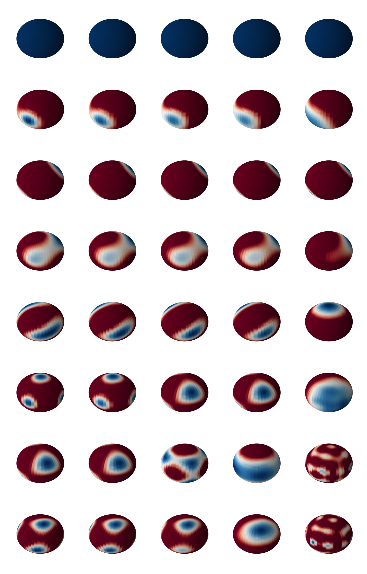

In [7]:

resolution = 50
c = 5.

x, y, z = generate_data(resolution)

data_locs = np.stack((x.flatten(),y.flatten(),z.flatten()),axis=-1)
data=np.copy(data_locs)
K = rbf_kernel(data.reshape(-1,3),data.reshape(-1,3), sigma=np.sqrt(5))
Kinv = pinvh(K,atol=0)
A = translation_T(data, c)

alphas = [0,1e-1,1e0,1e1,1e2]
n_eigs = 8

fig = plt.figure(figsize=[.3 * figsize_default[0]*len(alphas), .3* figsize_default[1]*n_eigs])

s0,v0 = eigh(A-alphas[0]*Kinv, subset_by_index=[len(A) - n_eigs, len(A) - 1])

for i, alpha in enumerate(alphas):
  s,v = eigh(A-alpha*Kinv, subset_by_index=[len(A)-n_eigs, len(A)-1])
  print(s[-10:])
  for j in range( n_eigs):
    ax = plt.subplot(n_eigs, len(alphas), 1 + len(alphas)*j + i,projection='3d')
    plot_spheres(ax, x, y, z, v[:,-j-1]*np.sign(np.sum(v0[:,-j-1]*v[:,-j-1])), alpha=0.8)
    setup_axis(ax)

  
fig.set_facecolor('none')

plt.savefig('sphere_full.jpg', bbox_inches='tight', rasterized=True, dpi=300)
plt.savefig('sphere_full_large.jpg', bbox_inches='tight', rasterized=True, dpi=600)


/tmp/ipykernel_108281/1698740576.py:45: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('sphere_min.jpg', bbox_inches='tight', rasterized=True, dpi=600)


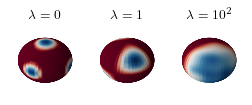

In [8]:
from matplotlib.text import Annotation
from scipy.interpolate import NearestNDInterpolator

alphas = [0,1e0,1e2]
n_eigs = 1
eig_choice = [6]

fig = plt.figure(figsize=figsize_default)

s0,v0 = eigh(A-alphas[0]*Kinv, subset_by_index=[len(A)-6, len(A)-1])

for i, alpha in enumerate(alphas):
  s,v = eigh(A-alpha*Kinv, subset_by_index=[len(A)-6, len(A)-1])
  for j in range(n_eigs):
    ax = plt.subplot(n_eigs, len(alphas), 1 + len(alphas)*j + i,projection='3d')
    interp = NearestNDInterpolator(data, v[:,-eig_choice[j]])
    plot_spheres(ax, x, y, z, interp(data_locs)*np.sign(np.sum(v0[:,-eig_choice[j]]*v[:,-eig_choice[j]])), alpha=.7)
    setup_axis(ax)
    
    if i==0:
      ax.set_ylabel('eigenfunction')
    if j == 0:
      if i == 0:
        ax.set_title('$\lambda=0$')
      if i == 1:
        ax.set_title('$\lambda=1$')
      if i == 2:
        ax.set_title('$\lambda=10^2$')

fig.set_facecolor('none')

# Get the position and size of the figure
bb = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# # Create the annotation object
# annotation = Annotation("Sample Eigenfunctions",
#                        xy=(0.15, 0.5), xycoords='figure fraction',
#                        xytext=(-20, 0), textcoords='offset points',
#                        ha='center', va='center',
#                        rotation=90)

# # Add the annotation to the figure
# fig.add_artist(annotation)

plt.savefig('sphere_min.jpg', bbox_inches='tight', rasterized=True, dpi=600)
